In [17]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import seaborn as sns
from matplotlib.colors import ListedColormap

sns.set_style(style='white')

In [2]:
import h5py

nGrid = 8

class zeldo_data:
    def load_data():

        z = 50
        hdf5_path = "../data/z" + str(z)+"_100.hdf5"
        hdf5_file = h5py.File(hdf5_path, mode='r')
        sim_z50 = hdf5_file["sims_z" + str(z)]
        
        z = 0
        hdf5_path = "../data/z" + str(z)+"_100.hdf5"
        hdf5_file = h5py.File(hdf5_path, mode='r')
        sim_z0 = hdf5_file["sims_z" + str(z)]
     
        train_test_split = 0.9
        split = np.int(train_test_split*sim_z0.shape[0])
        
        train_data = sim_z0[0:split, :, :, :]
        train_target = sim_z50[0:split, :, :, :]
        test_data = sim_z0[split:, :, :, :]
        test_target = sim_z50[split:, :, :, :]
        
        return (train_data[:, :nGrid, :nGrid, :nGrid], train_target[:, :nGrid, :nGrid, :nGrid]), (test_data[:, :nGrid, :nGrid, :nGrid], test_target[:, :nGrid, :nGrid, :nGrid])
    
    
(train_images, train_labels), (test_images, test_labels) = zeldo_data.load_data()
print(train_images.shape)

(90, 8, 8, 8)


In [3]:
# Network parameters

tf.app.flags.DEFINE_string('f', '', 'kernel')

tf.flags.DEFINE_float('learning_rate', .0005, 'Initial learning rate.')
tf.flags.DEFINE_integer('epochs', 20, 'Number of steps to run trainer.')
tf.flags.DEFINE_integer('batch_size', 1, 'Minibatch size')
tf.flags.DEFINE_integer('latent_dim', 4, 'Number of latent dimensions')
tf.flags.DEFINE_integer('test_image_number', 4, 'Number of test images to recover during training')
tf.flags.DEFINE_integer('inputs_decoder', 8, 'Size of decoder input layer')
tf.flags.DEFINE_string('dataset', 'zeldo', 'Dataset name [mnist, zeldo, fashion-mnist]')
tf.flags.DEFINE_string('logdir', './logs', 'Logs folder')
tf.flags.DEFINE_bool('plot_latent', True, 'Plot latent space')

FLAGS = tf.flags.FLAGS

In [4]:
# Define and create results folders
results_folder = os.path.join('Results', FLAGS.dataset)
[os.makedirs(os.path.join(results_folder, folder)) for folder in ['Test', 'Train']
    if not os.path.exists(os.path.join(results_folder, folder))]

# Empty log folder
try:
    if not len(os.listdir(FLAGS.logdir)) == 0:
        shutil.rmtree(FLAGS.logdir)
except:
    pass

In [5]:
# Get data
# data = zeldo_data if FLAGS.dataset == 'zeldo'
(train_images, train_labels), (test_images, test_labels) = zeldo_data.load_data()

tf.reset_default_graph()

# Create tf dataset
with tf.variable_scope("DataPipe"):
    dataset = tf.data.Dataset.from_tensor_slices(train_images)
    dataset = dataset.map(lambda x: tf.image.convert_image_dtype([x], dtype=tf.float32))
    dataset = dataset.batch(batch_size=FLAGS.batch_size).prefetch(FLAGS.batch_size)

    iterator = dataset.make_initializable_iterator()
    input_batch = iterator.get_next()
    input_batch = tf.reshape(input_batch, shape=[-1, nGrid, nGrid, nGrid, 1])

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [6]:
def encoder(X):
    activation = tf.nn.relu
    with tf.variable_scope("Encoder"):
        x = tf.layers.conv3d(inputs=X, filters=16, kernel_size=[4,4,4], padding='same', activation=activation)
        x = tf.layers.conv3d(inputs=x, filters=16, kernel_size=[4,4,4], padding='same', activation=activation)
#         x = tf.layers.conv3d(inputs=x, filters=64, kernel_size=[4,4,4], padding='same', activation=activation)
        x = tf.layers.flatten(x)

        x = tf.layers.dense(x, units=8*FLAGS.latent_dim)
        x = tf.layers.dense(x, units=4*FLAGS.latent_dim)
        x = tf.layers.dense(x, units=2*FLAGS.latent_dim)

        # Local latent variables
        mean_ = tf.layers.dense(x, units=FLAGS.latent_dim, name='mean')
        std_dev = tf.nn.softplus(tf.layers.dense(x, units=FLAGS.latent_dim), name='std_dev')  # softplus to force >0

        # Reparametrization trick
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], FLAGS.latent_dim]), name='epsilon')
        z = mean_ + tf.multiply(epsilon, std_dev)

        return z, mean_, std_dev

def decoder(z):
    activation = tf.nn.relu
    with tf.variable_scope("Decoder"):
        
        x = tf.layers.dense(z, units=FLAGS.inputs_decoder, activation=activation)
        x = tf.layers.dense(x, units=2*FLAGS.inputs_decoder, activation=activation)
        x = tf.layers.dense(x, units=4*FLAGS.inputs_decoder, activation=activation)
        x = tf.layers.dense(x, units=8*FLAGS.inputs_decoder, activation=activation)
        
        recovered_size = int(np.cbrt(FLAGS.inputs_decoder))
        x = tf.reshape(x, [-1, recovered_size, recovered_size, recovered_size, 1])

        x = tf.layers.conv3d_transpose(x, filters=16, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.layers.conv3d_transpose(x, filters=16, kernel_size=4, strides=1, padding='same', activation=activation)
#         x = tf.layers.conv3d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)

        x = tf.contrib.layers.flatten(x)

        x = tf.layers.dense(x, units= nGrid*nGrid*nGrid, activation=None)

        x = tf.layers.dense(x, units=nGrid*nGrid*nGrid, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, nGrid, nGrid, nGrid, 1])
        return img



In [18]:
# Link encoder and decoder
z, mean_, std_dev = encoder(input_batch)
output = decoder(z)

# Reshape input and output to flat vectors
flat_output = tf.reshape(output, [-1, nGrid*nGrid*nGrid])
flat_input = tf.reshape(input_batch, [-1, nGrid*nGrid*nGrid])

with tf.name_scope('loss'):
    img_loss = tf.reduce_sum(flat_input * -tf.log(flat_output) + (1 - flat_input) * -tf.log(1 - flat_output), 1)
    latent_loss = 0.5 * tf.reduce_sum(tf.square(mean_) + tf.square(std_dev) - tf.log(tf.square(std_dev)) - 1, 1)
    loss = tf.reduce_mean(img_loss + latent_loss)
    tf.summary.scalar('batch_loss', loss)

optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate).minimize(loss)


init_vars = [tf.local_variables_initializer(), tf.global_variables_initializer()]
# gpu_options = tf.GPUOptions(allow_growth=True)

In [16]:
# Training loop
# with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
with tf.Session(config=tf.ConfigProto()) as sess:

    writer = tf.summary.FileWriter('./logs', sess.graph)

    sess.run(init_vars)
    merged_summary_op = tf.summary.merge_all()

    for epoch in range(FLAGS.epochs):
        sess.run(iterator.initializer)
        print('Actual epoch: {}'.format(epoch))
        print(epoch)
        
        

        flag = True  # Show only first batch of epoch

        while True:
            try:
                sess.run(optimizer)
                if flag:
                    # Get input and recover output images comparison
                    summ, target, output_ = sess.run([merged_summary_op, input_batch, output])
                    f, axarr = plt.subplots(FLAGS.test_image_number, 2)

                    only1 = True
                    
                    if only1: 
                        plt.imshow(im[0].reshape((nGrid, nGrid, nGrid))[0], cmap='gray')
                    else: 
                        for j in range(FLAGS.test_image_number):
                            for pos, im in enumerate([target, output_]):
                                axarr[j, pos].imshow(im[j].reshape((nGrid, nGrid, nGrid))[0], cmap='gray')
                                axarr[j, pos].axis('off')
                                print(j)

                    plt.savefig(os.path.join(results_folder, 'Train/Epoch_{}').format(epoch))
                    plt.close(f)
                    flag = False
                    writer.add_summary(summ, epoch)

                    # Create artificial image from unit norm sample
                    artificial_image = sess.run(output, feed_dict={z: np.random.normal(0, 1, (1, FLAGS.latent_dim))})
                    plt.figure()
                    with sns.axes_style("white"):
                        plt.imshow(artificial_image[0].reshape((nGrid, nGrid, nGrid))[0], cmap='gray')
                    plt.savefig(os.path.join(results_folder, 'Test/{}'.format(epoch)))
                    plt.close()

                    # Create plot of latent space (only if latent dimensions are 2)
                    if FLAGS.latent_dim == 2 and FLAGS.plot_latent:
                        coords = sess.run(z, feed_dict={input_batch: test_images[..., np.newaxis]})
                        colormap = ListedColormap(sns.color_palette(sns.hls_palette(10, l=.45 , s=.8)).as_hex())
                        plt.scatter(coords[:, 0], coords[:, 1], c=test_labels, cmap=colormap)

                        cbar = plt.colorbar()

                        plt.axis('off')
                        plt.title('Latent space')
                        plt.savefig(os.path.join(results_folder, 'Test/Latent_{}'.format(epoch)))
                        plt.close()

            except tf.errors.OutOfRangeError:
                break

        # Create mesh grid of values
        values = np.arange(-3, 4, .5)
        xx, yy = np.meshgrid(values, values)
        input_holder = np.zeros((1, 2))
        # Matrix that will contain the grid of images
        container = np.zeros((nGrid * len(values), nGrid * len(values)))

        for row in range(xx.shape[0]):
            for col in range(xx.shape[1]):
                input_holder[0, :] = [xx[row, col], yy[row, col]]
                artificial_image = sess.run(output, feed_dict={z: input_holder})
                container[row * nGrid: (row + 1) * nGrid, col * nGrid: (col + 1) * nGrid] = np.squeeze(artificial_image)

        plt.imshow(container, cmap='gray')
        plt.savefig(os.path.join(results_folder, 'Test/Space_{}'.format(epoch)))
        plt.close(  )

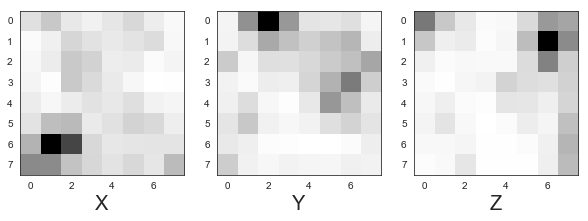

In [15]:
simID = 0
gen_z50 = im[:,:,:,:,0]
slice = 1

fig, ax = plt.subplots(1, 3, figsize = (10,  8))
ax[0].imshow(gen_z50[simID, slice, :, :], cmap='gray_r')
ax[1].imshow(gen_z50[simID, :, slice, :], cmap='gray_r')
ax[2].imshow(gen_z50[simID, :, :, slice], cmap='gray_r')

# ax[1, 0].imshow(gen_z0[simID, slice, :, :], cmap='gray_r')
# ax[1, 1].imshow(gen_z0[simID, :, slice, :], cmap='gray_r')
# ax[1, 2].imshow(gen_z0[simID, :, :, slice], cmap='gray_r')

ax[0].set_xlabel('X',fontsize=20)
ax[1].set_xlabel('Y', fontsize=20)
ax[2].set_xlabel('Z', fontsize=20)

# ax[0, 0].set_ylabel('z = 50', rotation=0, fontsize=20, labelpad=40)
# ax[1, 0].set_ylabel('z = 0', rotation=0, fontsize=20, labelpad=40)

plt.show()